In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from lib.dataset import *
from lib.model import *
from lib.engine import *

In [2]:
seq_length= 128
batch_size = 2048
test_data_path = "./datasets/35Hz12kN/Bearing1_1/" 
rul_model_path="./models/rul_model.pth"
gan_model_path="./models/sample_gan_model.pth"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
class BearingDataset(Dataset):
    def __init__(self, vibration, rul, seq_length, device):
        self.vibration = vibration
        self.rul = rul
        self.seq_length = seq_length
        self.device = device

    def __len__(self):
        return len(self.rul) - self.seq_length + 1

    def __getitem__(self, idx):
        x = self.vibration[idx:idx + self.seq_length]
        y = self.rul[idx + self.seq_length - 1]

        x = torch.tensor(x, dtype=torch.float32).to(self.device)
        y = torch.tensor(y, dtype=torch.float32).to(self.device)

        return x, y

In [4]:
df = load_data(test_data_path)
df

Load Dataset: ./datasets/35Hz12kN/Bearing1_1/: 100%|██████████| 123/123 [00:02<00:00, 47.92it/s]


,Horizontal_vibration_signals,Vertical_vibration_signals
0,-0.396395,-0.038672
1,-0.123107,-0.365901
2,0.988841,-0.583780
3,0.006676,-0.013411
4,-1.074386,0.087607
...,...,...
4030459,-1.983047,0.486004
4030460,-9.157157,3.498781
4030461,-4.796529,0.254321
4030462,-9.346092,2.056193


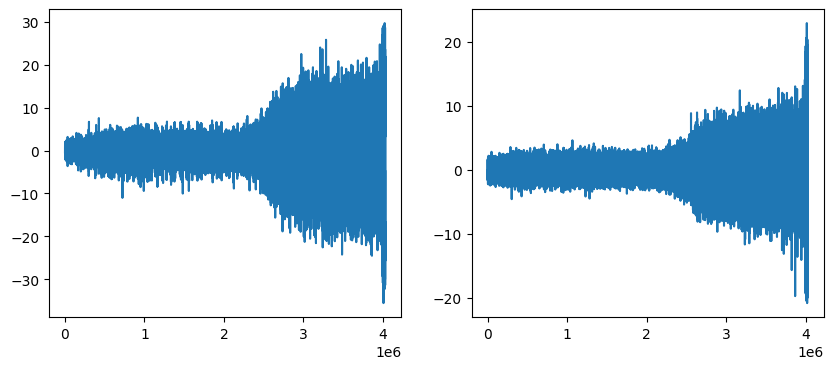

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
df["Horizontal_vibration_signals"].plot()

plt.subplot(1, 2, 2)
df["Vertical_vibration_signals"].plot()

plt.show()

In [6]:
df = preprocess_data(df)
df

,Horizontal_vibration_signals,Vertical_vibration_signals,RUL,Normalized_RUL
0,-0.396395,-0.038672,4030463,1.000000e+00
1,-0.123107,-0.365901,4030462,9.999998e-01
2,0.988841,-0.583780,4030461,9.999995e-01
3,0.006676,-0.013411,4030460,9.999993e-01
4,-1.074386,0.087607,4030459,9.999990e-01
...,...,...,...,...
4030459,-1.983047,0.486004,4,9.924418e-07
4030460,-9.157157,3.498781,3,7.443314e-07
4030461,-4.796529,0.254321,2,4.962209e-07
4030462,-9.346092,2.056193,1,2.481105e-07


In [7]:
vibration = df[['Horizontal_vibration_signals', 'Vertical_vibration_signals']].values
rul = df['Normalized_RUL'].values

dataset = BearingDataset(vibration, rul, seq_length, device)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [8]:
input_channels= 2
hidden_size= 64
num_layers= 4

rul_model = DegradationModel(
    input_channels, 
    hidden_size, 
    num_layers, 
    seq_length, 
    device).to(device)

rul_model.load_state_dict(torch.load(rul_model_path))
rul_model

DegradationModel(
  (conv): ResConv1dBlock(
    (conv1): Conv1d(2, 2, kernel_size=(3,), stride=(1,), padding=(1,))
    (norm1): InstanceNorm1d(2, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): ReLU()
  )
  (bilstm): BiLSTM(
    (lstm): LSTM(2, 64, num_layers=4, batch_first=True, bidirectional=True)
    (relu): ReLU()
  )
  (reg): Regressor(
    (fc1): Linear(in_features=128, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=16, bias=True)
    (fc3): Linear(in_features=16, out_features=1, bias=True)
    (relu): ReLU()
  )
)

In [9]:
input_channels= 2
hidden_size= 64
num_layers= 2

generator = Generator(
    input_channel=input_channels,
    hidden_channel=hidden_size,
    num_layers=num_layers
).to(device)
generator.load_state_dict(torch.load(gan_model_path))
generator

Generator(
  (lstm): LSTM(2, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

In [12]:
def rmse_loss_function(pred, target):
    loss = F.mse_loss(pred, target, reduction='mean')
    rmse_loss = torch.sqrt(loss)
    return rmse_loss

optimizer = optim.AdamW(rul_model.parameters(), lr=0.01)

num_augmented_samples = 1
num_epochs = 1

for epoch in range(1, num_epochs+1):
    train_meta_task(
        epoch,num_epochs,1,1,
        rul_model, 
        dataloader,
        rmse_loss_function, 
        optimizer,
        device, 
        generator,
        num_augmented_samples
        )


Training... Epoch: 1/1, Inner Step: 1/1: 100%|██████████| 1968/1968 [07:06<00:00,  4.61it/s]


In [13]:

test_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [14]:
rul_model.eval()

predicted_ruls = []
true_ruls = []
with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Testing..."):
        x, y = batch
        y = y.view(-1,1)
        pred = rul_model(x)
        predicted_ruls.extend(pred.cpu().numpy())
        true_ruls.extend(y.cpu().numpy())

predicted_ruls = np.array(predicted_ruls).flatten()
true_ruls = np.array(true_ruls).flatten()

predicted_ruls

Testing...: 100%|██████████| 1968/1968 [04:02<00:00,  8.11it/s]


array([ 9.5603406e-01,  9.5820415e-01,  9.5672029e-01, ...,
       -1.0976642e-03, -5.1295757e-04, -3.0784309e-04], dtype=float32)

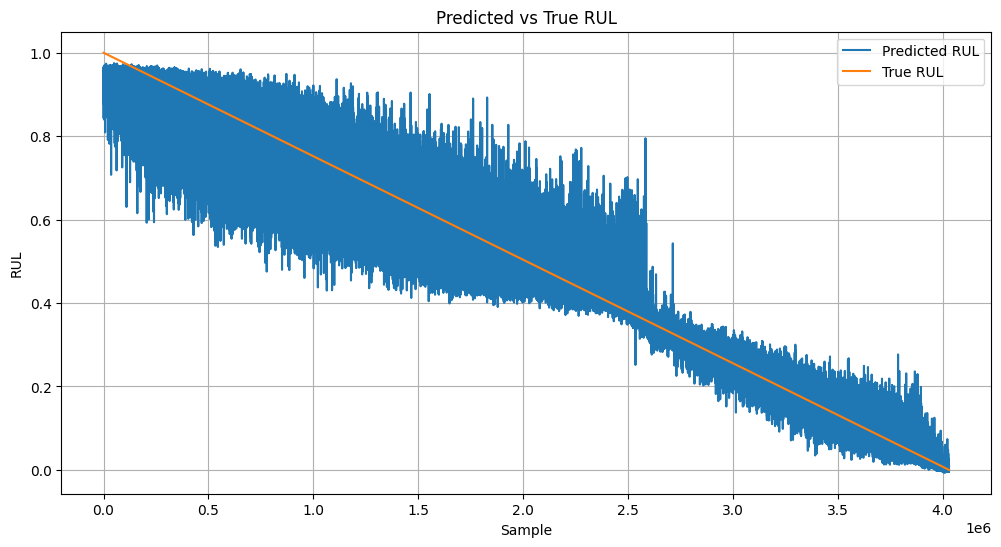

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(predicted_ruls, label='Predicted RUL')
plt.plot(true_ruls, label='True RUL')
plt.xlabel('Sample')
plt.ylabel('RUL')
plt.title('Predicted vs True RUL')
plt.legend()
plt.grid(True)
plt.show()
